# ライブラリのインポート

In [9]:
# データ処理
import numpy as np
import pandas as pd
from pathlib import Path

# 画像処理
from PIL import Image
import io

# 可視化
import matplotlib.pyplot as plt

FONT_NAME = "IPAexGothic"
plt.rcParams['font.family'] = FONT_NAME
plt.rcParams['font.sans-serif'] = [FONT_NAME]
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

# parquetファイルの読み込み
import pyarrow.parquet as pq

# プログレスバー（オプション）
from tqdm import tqdm

# 日本語フォント設定（オプション）
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


# データの読み込み

In [10]:
# データセットのパス
dataset_path = Path("./MultimodalUniverse/galaxy10_decals/dataset")

# parquetファイルのリスト
parquet_files = sorted(dataset_path.glob("*.parquet"))
print(f"見つかったparquetファイル: {len(parquet_files)}個")
for f in parquet_files:
    print(f"  - {f.name}")

if len(parquet_files) == 0:
    import os
    print(os.getcwd())
    print(os.listdir('.'))
    raise FileNotFoundError("parquetファイルが見つかりません。パスを確認してください。")

# 最初のファイルを読み込んで構造を確認
df = pd.read_parquet(parquet_files[0])
print(f"\n✅ データ読み込み完了")
print(f"行数: {len(df)}")
print(f"列: {df.columns.tolist()}")
print(f"\nデータ型:")
print(df.dtypes)

見つかったparquetファイル: 2個
  - train-00000-of-00002.parquet
  - train-00001-of-00002.parquet

✅ データ読み込み完了
行数: 8868
列: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale']

データ型:
gz10_label           int32
redshift           float32
object_id           object
rgb_image           object
rgb_pixel_scale    float32
dtype: object


# データの中身を確認

In [11]:
# 最初の数行を表示
print("最初の3行（画像以外）:")
print(df[['gz10_label', 'redshift', 'object_id', 'rgb_pixel_scale']].head(3))

# 各列の詳細情報
print("\n各列の情報:")
print(f"  gz10_label: ラベル（0-9の整数）")
print(f"  redshift: 赤方偏移（銀河までの距離に相関）")
print(f"  object_id: 天体の識別ID")
print(f"  rgb_image: RGB画像データ")
print(f"  rgb_pixel_scale: ピクセルスケール（角度分解能）")

# ラベルの分布を確認
print("\nラベルの分布:")
label_counts = df['gz10_label'].value_counts().sort_index()
print(label_counts)

# 赤方偏移の統計
print("\n赤方偏移の統計:")
print(f"  最小値: {df['redshift'].min():.4f}")
print(f"  最大値: {df['redshift'].max():.4f}")
print(f"  平均値: {df['redshift'].mean():.4f}")
print(f"  中央値: {df['redshift'].median():.4f}")

最初の3行（画像以外）:
   gz10_label  redshift object_id  rgb_pixel_scale
0           0  0.072587       904            0.262
1           1  0.134578      1558            0.262
2           1  0.129557      1768            0.262

各列の情報:
  gz10_label: ラベル（0-9の整数）
  redshift: 赤方偏移（銀河までの距離に相関）
  object_id: 天体の識別ID
  rgb_image: RGB画像データ
  rgb_pixel_scale: ピクセルスケール（角度分解能）

ラベルの分布:
gz10_label
0     552
1    1050
2    1604
3     713
4     121
5     953
6    1027
7     963
8     628
9    1257
Name: count, dtype: int64

赤方偏移の統計:
  最小値: 0.0000
  最大値: 1.1554
  平均値: 0.0816
  中央値: 0.0796


# 画像データの展開

画像データの例（最初の1サンプル）:
型: <class 'dict'>
辞書のキー: dict_keys(['bytes', 'path'])
画像データの型: <class 'bytes'>

✅ 画像の読み込み成功
画像サイズ: (256, 256)
画像モード: RGB


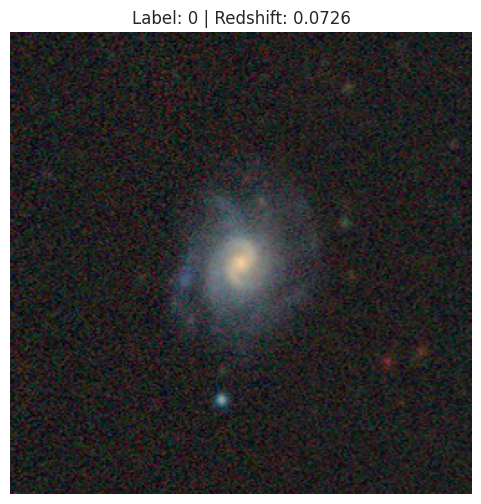

In [12]:
# 画像データの形式を確認
print("画像データの例（最初の1サンプル）:")
image_data = df.iloc[0]['rgb_image']
print(f"型: {type(image_data)}")

# rgb_imageの中身を確認
if isinstance(image_data, dict):
    print(f"辞書のキー: {image_data.keys()}")
    print(f"画像データの型: {type(image_data.get('bytes') or image_data.get('path'))}")

# 画像をPIL Imageに変換する関数
def get_image_from_row(row):
    """DataFrameの行からPIL Imageを取得"""
    image_data = row['rgb_image']
    
    if isinstance(image_data, dict):
        if 'bytes' in image_data:
            # バイト列から読み込み
            return Image.open(io.BytesIO(image_data['bytes']))
        elif 'path' in image_data:
            # ファイルパスから読み込み
            return Image.open(image_data['path'])
    elif isinstance(image_data, bytes):
        # 直接バイト列の場合
        return Image.open(io.BytesIO(image_data))
    else:
        raise ValueError(f"Unknown image format: {type(image_data)}")

# 試しに1枚表示
sample_row = df.iloc[0]
img = get_image_from_row(sample_row)
print(f"\n✅ 画像の読み込み成功")
print(f"画像サイズ: {img.size}")
print(f"画像モード: {img.mode}")

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Label: {sample_row['gz10_label']} | Redshift: {sample_row['redshift']:.4f}")
plt.axis('off')
plt.show()

# クラス分布

全parquetファイルを読み込み中...

✅ 全データ読み込み完了
総サンプル数: 17736


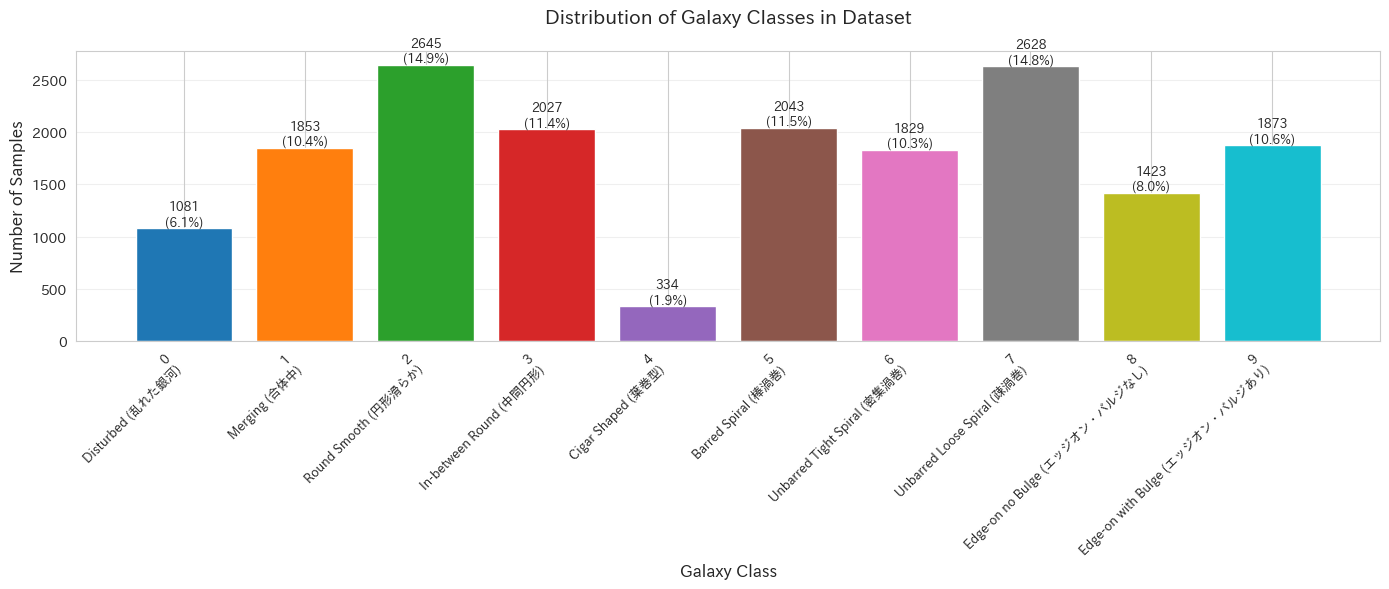


クラス不均衡の分析:
  最大クラス: 2 (2645サンプル)
  最小クラス: 4 (334サンプル)
  不均衡比: 7.92倍


In [14]:
# https://astronn.readthedocs.io/en/latest/galaxy10.html
# Galaxy10の10クラス
class_names = {
    0: 'Disturbed (乱れた銀河)',
    1: 'Merging (合体中)',
    2: 'Round Smooth (円形滑らか)',
    3: 'In-between Round (中間円形)',
    4: 'Cigar Shaped (葉巻型)',
    5: 'Barred Spiral (棒渦巻)',
    6: 'Unbarred Tight Spiral (密集渦巻)',
    7: 'Unbarred Loose Spiral (疎渦巻)',
    8: 'Edge-on no Bulge (エッジオン・バルジなし)',
    9: 'Edge-on with Bulge (エッジオン・バルジあり)'
}

FONT_NAME = "IPAexGothic"
plt.rcParams['font.family'] = FONT_NAME
plt.rcParams['font.sans-serif'] = [FONT_NAME]
plt.rcParams['axes.unicode_minus'] = False


# 全parquetファイルを読み込んで統計を取る
print("全parquetファイルを読み込み中...")
all_dfs = []
for pf in parquet_files:
    all_dfs.append(pd.read_parquet(pf))
df_all = pd.concat(all_dfs, ignore_index=True)

print(f"\n✅ 全データ読み込み完了")
print(f"総サンプル数: {len(df_all)}")

# クラス分布を可視化
label_counts = df_all['gz10_label'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(label_counts)), label_counts.values, 
               color=plt.cm.tab10(range(len(label_counts))))
plt.xticks(range(len(class_names)), 
           [f"{i}\n{class_names[i]}" for i in range(len(class_names))],
           rotation=45, ha='right', fontsize=9)
plt.xlabel('Galaxy Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Galaxy Classes in Dataset', fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# 各バーに数値とパーセンテージを表示
total = len(df_all)
for bar, count in zip(bars, label_counts.values):
    height = bar.get_height()
    percentage = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# クラス不均衡の分析
print("\nクラス不均衡の分析:")
max_count = label_counts.max()
min_count = label_counts.min()
print(f"  最大クラス: {label_counts.idxmax()} ({max_count}サンプル)")
print(f"  最小クラス: {label_counts.idxmin()} ({min_count}サンプル)")
print(f"  不均衡比: {max_count / min_count:.2f}倍")


# クラス不均衡対策の計算

In [15]:
print("=" * 60)
print("クラス不均衡への対策")
print("=" * 60)

# クラスウェイトの計算（PyTorchで使用）
from sklearn.utils.class_weight import compute_class_weight

# クラスウェイトを計算
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_all['gz10_label']),
    y=df_all['gz10_label']
)

print("\n1. クラスウェイト（balanced）:")
print("   損失関数で使用して、少数クラスの重要度を上げる")
for i, weight in enumerate(class_weights):
    print(f"   クラス {i} ({class_names[i]}): {weight:.3f}")

# PyTorch用のテンソルに変換
import torch
class_weights_tensor = torch.FloatTensor(class_weights)
print(f"\nPyTorchでの使用例:")
print(f"criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)")

# 2. 各クラスのサンプリング確率
print("\n2. オーバーサンプリング/アンダーサンプリング:")
max_samples = label_counts.max()
min_samples = label_counts.min()
median_samples = int(label_counts.median())

print(f"   最大サンプル数: {max_samples} (クラス2)")
print(f"   最小サンプル数: {min_samples} (クラス4)")
print(f"   中央値: {median_samples}")
print(f"   → 中央値にバランスさせる戦略も有効")

# 3. データ拡張の重要性
print("\n3. データ拡張（Data Augmentation）:")
print("   少数クラスに対してより積極的な拡張を適用")
print("   - 回転（0-360度）")
print("   - 水平/垂直反転")
print("   - ズーム")
print("   - 明るさ/コントラスト調整")
print("   - ノイズ追加")
print("   → これで実質的なサンプル数を増やせる")

print("\n推奨アプローチ:")
print("  ✅ クラスウェイトを使った学習")
print("  ✅ データ拡張で少数クラスを増強")
print("  ✅ 学習時のバランスサンプリング（WeightedRandomSampler）")
print("=" * 60)


クラス不均衡への対策

1. クラスウェイト（balanced）:
   損失関数で使用して、少数クラスの重要度を上げる
   クラス 0 (Disturbed (乱れた銀河)): 1.641
   クラス 1 (Merging (合体中)): 0.957
   クラス 2 (Round Smooth (円形滑らか)): 0.671
   クラス 3 (In-between Round (中間円形)): 0.875
   クラス 4 (Cigar Shaped (葉巻型)): 5.310
   クラス 5 (Barred Spiral (棒渦巻)): 0.868
   クラス 6 (Unbarred Tight Spiral (密集渦巻)): 0.970
   クラス 7 (Unbarred Loose Spiral (疎渦巻)): 0.675
   クラス 8 (Edge-on no Bulge (エッジオン・バルジなし)): 1.246
   クラス 9 (Edge-on with Bulge (エッジオン・バルジあり)): 0.947

PyTorchでの使用例:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

2. オーバーサンプリング/アンダーサンプリング:
   最大サンプル数: 2645 (クラス2)
   最小サンプル数: 334 (クラス4)
   中央値: 1863
   → 中央値にバランスさせる戦略も有効

3. データ拡張（Data Augmentation）:
   少数クラスに対してより積極的な拡張を適用
   - 回転（0-360度）
   - 水平/垂直反転
   - ズーム
   - 明るさ/コントラスト調整
   - ノイズ追加
   → これで実質的なサンプル数を増やせる

推奨アプローチ:
  ✅ クラスウェイトを使った学習
  ✅ データ拡張で少数クラスを増強
  ✅ 学習時のバランスサンプリング（WeightedRandomSampler）


# セル7: 不均衡なクラスの比較

クラス2 (最多) と クラス4 (最少) の比較


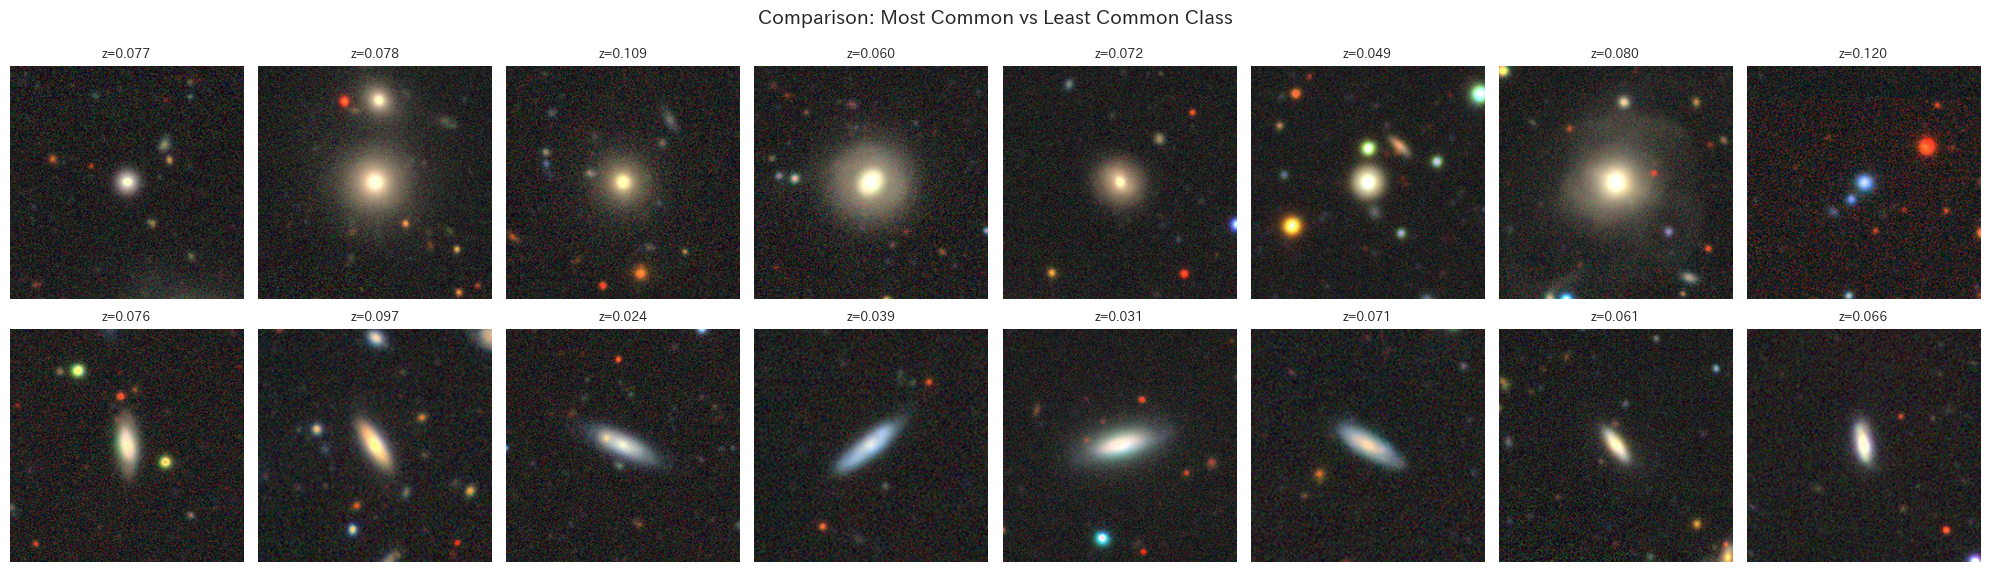

In [16]:
# 最大クラスと最小クラスを比較
fig, axes = plt.subplots(2, 8, figsize=(20, 6))

print("クラス2 (最多) と クラス4 (最少) の比較")

# クラス2 (最多): Round Smooth
class_2_samples = df_all[df_all['gz10_label'] == 2].sample(n=8, random_state=42)
for i, (_, sample) in enumerate(class_2_samples.iterrows()):
    img = get_image_from_row(sample)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'z={sample["redshift"]:.3f}', fontsize=9)
    axes[0, i].axis('off')

axes[0, 0].set_ylabel('Class 2\n(2645 samples)', fontsize=12, rotation=0, 
                      ha='right', va='center', labelpad=40)

# クラス4 (最少): Cigar Shaped
class_4_samples = df_all[df_all['gz10_label'] == 4].sample(n=8, random_state=42)
for i, (_, sample) in enumerate(class_4_samples.iterrows()):
    img = get_image_from_row(sample)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'z={sample["redshift"]:.3f}', fontsize=9)
    axes[1, i].axis('off')

axes[1, 0].set_ylabel('Class 4\n(334 samples)', fontsize=12, rotation=0,
                      ha='right', va='center', labelpad=40)

plt.suptitle('Comparison: Most Common vs Least Common Class', fontsize=14)
plt.tight_layout()
plt.show()

# 画像サイズと統計情報

画像の詳細統計を計算中（サンプル数: 50）...

✅ 統計計算完了
画像配列の形状: (50, 256, 256, 3)
  - サンプル数: 50
  - 高さ: 256 pixels
  - 幅: 256 pixels
  - チャンネル数: 3 (RGB)

ピクセル値の統計:
  データ型: uint8
  最小値: 0
  最大値: 255
  平均値: 41.55
  標準偏差: 30.31

RGBチャンネル別統計:
  Redチャンネル:
    平均: 42.59
    標準偏差: 32.84
    [最小, 最大]: [0, 255]
  Greenチャンネル:
    平均: 41.59
    標準偏差: 29.70
    [最小, 最大]: [0, 255]
  Blueチャンネル:
    平均: 40.45
    標準偏差: 28.18
    [最小, 最大]: [0, 255]


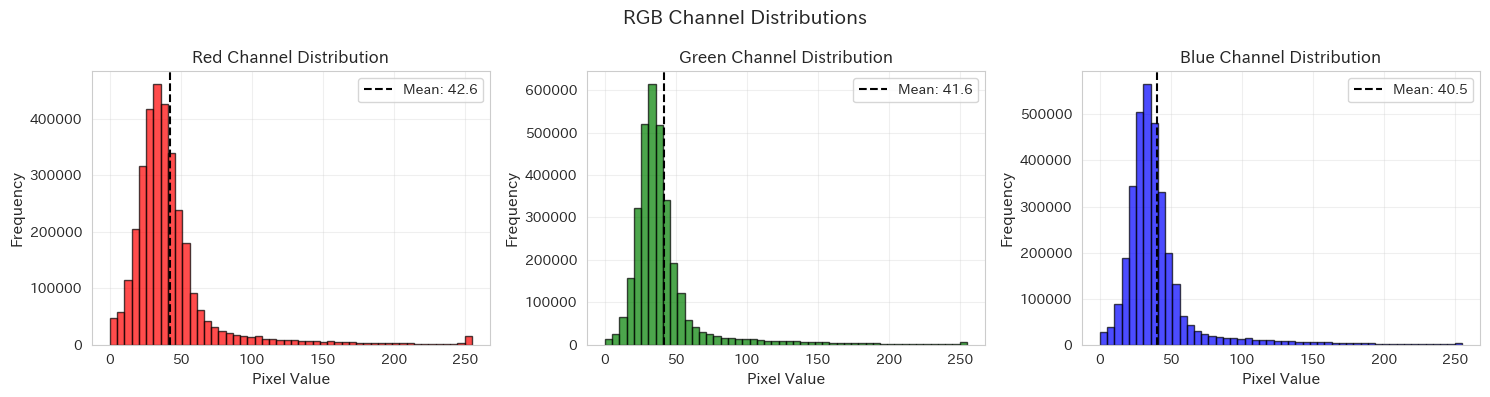


💡 正規化の推奨:
  方法1: 0-1正規化  → image / 255.0
  方法2: 標準化     → (image - mean) / std
  方法3: ImageNet正規化 → transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [17]:
# 複数画像から統計を取る
print("画像の詳細統計を計算中（サンプル数: 50）...")
sample_images = []
sample_size = min(50, len(df_all))

for i in range(sample_size):
    img = get_image_from_row(df_all.iloc[i])
    img_array = np.array(img)
    sample_images.append(img_array)

sample_images = np.array(sample_images)

print(f"\n✅ 統計計算完了")
print(f"画像配列の形状: {sample_images.shape}")
print(f"  - サンプル数: {sample_images.shape[0]}")
print(f"  - 高さ: {sample_images.shape[1]} pixels")
print(f"  - 幅: {sample_images.shape[2]} pixels")
print(f"  - チャンネル数: {sample_images.shape[3]} (RGB)")

print(f"\nピクセル値の統計:")
print(f"  データ型: {sample_images.dtype}")
print(f"  最小値: {sample_images.min()}")
print(f"  最大値: {sample_images.max()}")
print(f"  平均値: {sample_images.mean():.2f}")
print(f"  標準偏差: {sample_images.std():.2f}")

# RGBチャンネルごとの統計
print("\nRGBチャンネル別統計:")
channel_names = ['Red', 'Green', 'Blue']
for ch, name in enumerate(channel_names):
    ch_data = sample_images[:, :, :, ch]
    print(f"  {name}チャンネル:")
    print(f"    平均: {ch_data.mean():.2f}")
    print(f"    標準偏差: {ch_data.std():.2f}")
    print(f"    [最小, 最大]: [{ch_data.min()}, {ch_data.max()}]")

# ヒストグラムで可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['red', 'green', 'blue']

for ch, (name, color) in enumerate(zip(channel_names, colors)):
    ch_data = sample_images[:, :, :, ch].flatten()
    axes[ch].hist(ch_data, bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[ch].set_xlabel('Pixel Value', fontsize=11)
    axes[ch].set_ylabel('Frequency', fontsize=11)
    axes[ch].set_title(f'{name} Channel Distribution', fontsize=12)
    axes[ch].axvline(ch_data.mean(), color='black', linestyle='--', 
                     label=f'Mean: {ch_data.mean():.1f}')
    axes[ch].legend()
    axes[ch].grid(alpha=0.3)

plt.suptitle('RGB Channel Distributions', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 正規化の推奨:")
print("  方法1: 0-1正規化  → image / 255.0")
print("  方法2: 標準化     → (image - mean) / std")
print("  方法3: ImageNet正規化 → transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])")


# 各クラスのサンプル画像表示

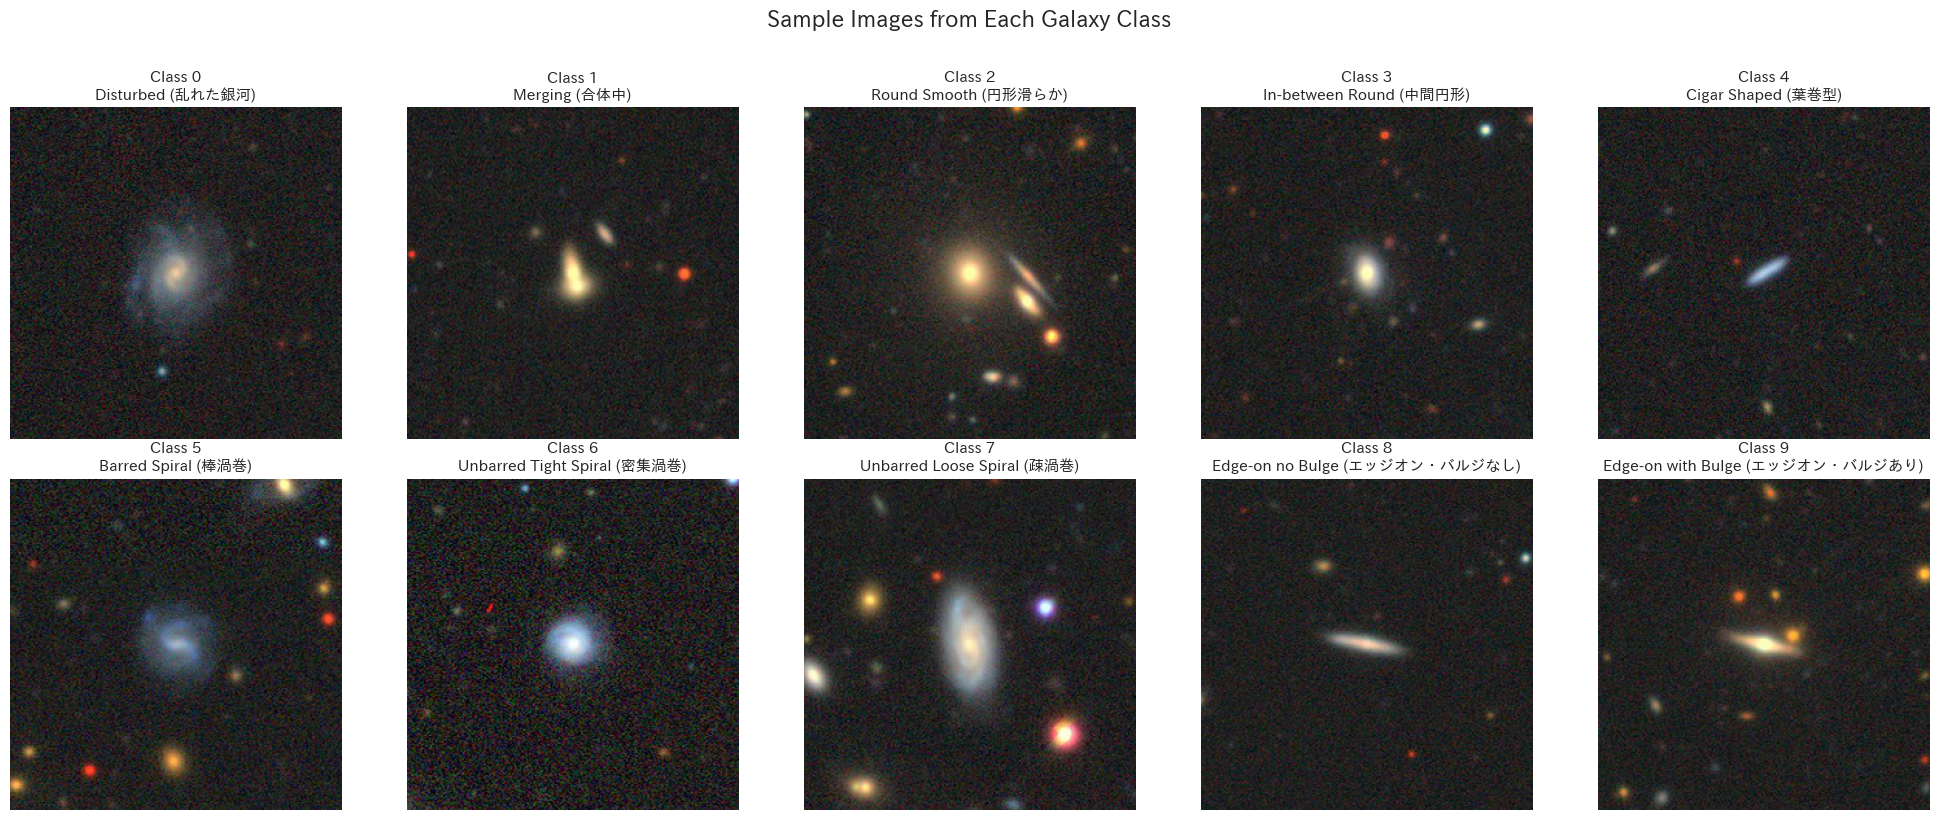

In [21]:
# 各クラスから1枚ずつ表示
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i in range(10):
    # クラスiの最初のサンプルを取得
    sample = df_all[df_all['gz10_label'] == i].iloc[0]
    img = get_image_from_row(sample)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Class {i}\n{class_names[i]}", fontsize=11)
    axes[i].axis('off')

plt.suptitle('Sample Images from Each Galaxy Class', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 画像の統計情報

In [24]:
# 複数の画像を読み込んで統計を取る
print("画像の統計情報を計算中（100サンプル）...")
sample_images = []

for i in range(min(100, len(df_all))):
    img = get_image_from_row(df_all.iloc[i])
    img_array = np.array(img)
    sample_images.append(img_array)

sample_images = np.array(sample_images)

print(f"\n画像配列の形状: {sample_images.shape}")
print(f"データ型: {sample_images.dtype}")
print(f"ピクセル値の範囲: [{sample_images.min()}, {sample_images.max()}]")
print(f"平均値: {sample_images.mean():.2f}")
print(f"標準偏差: {sample_images.std():.2f}")

# RGBチャンネルごとの統計
if len(sample_images.shape) == 4:  # (N, H, W, C)
    print("\nRGBチャンネル別統計:")
    for ch, name in enumerate(['Red', 'Green', 'Blue']):
        print(f"  {name}:")
        print(f"    平均: {sample_images[:,:,:,ch].mean():.2f}")
        print(f"    標準偏差: {sample_images[:,:,:,ch].std():.2f}")


画像の統計情報を計算中（100サンプル）...

画像配列の形状: (100, 256, 256, 3)
データ型: uint8
ピクセル値の範囲: [0, 255]
平均値: 42.02
標準偏差: 30.22

RGBチャンネル別統計:
  Red:
    平均: 43.19
    標準偏差: 33.02
  Green:
    平均: 42.15
    標準偏差: 29.68
  Blue:
    平均: 40.72
    標準偏差: 27.67


# クラスウェイトの保存

In [25]:
# クラスウェイトを保存
import pickle

# 保存するデータ
data_info = {
    'class_weights': class_weights,  # リスト
    'class_weights_tensor': class_weights_tensor,  # PyTorchテンソル
    'class_names': class_names,  # 辞書
    'label_counts': label_counts.to_dict(),  # 各クラスのサンプル数
    'rgb_mean': [43.19/255, 42.15/255, 40.72/255],  # 正規化用
    'rgb_std': [33.02/255, 29.68/255, 27.67/255],   # 正規化用
    'total_samples': len(df_all),
    'image_size': (256, 256)
}

# ファイルに保存
output_path = Path('./MultimodalUniverse/galaxy10_decals/dataset/data_info.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(data_info, f)

print(f"✅ データ情報を保存しました: {output_path}")
print("\n保存内容:")
for key, value in data_info.items():
    if isinstance(value, (list, dict)) and len(str(value)) > 100:
        print(f"  {key}: (省略)")
    else:
        print(f"  {key}: {value}")


✅ データ情報を保存しました: MultimodalUniverse/galaxy10_decals/dataset/data_info.pkl

保存内容:
  class_weights: [1.64070305 0.95715057 0.6705482  0.87498767 5.31017964 0.8681351
 0.96971022 0.67488584 1.24638089 0.94693006]
  class_weights_tensor: tensor([1.6407, 0.9572, 0.6705, 0.8750, 5.3102, 0.8681, 0.9697, 0.6749, 1.2464,
        0.9469])
  class_names: (省略)
  label_counts: {0: 1081, 1: 1853, 2: 2645, 3: 2027, 4: 334, 5: 2043, 6: 1829, 7: 2628, 8: 1423, 9: 1873}
  rgb_mean: [0.16937254901960783, 0.1652941176470588, 0.1596862745098039]
  rgb_std: [0.12949019607843137, 0.1163921568627451, 0.10850980392156863]
  total_samples: 17736
  image_size: (256, 256)


In [ ]:
print("=" * 70)
print("📊 データ探索のまとめ")
print("=" * 70)

print("\n【データセット情報】")
print(f"  総サンプル数: {len(df_all):,}")
print(f"  クラス数: {len(class_names)}")
print(f"  画像サイズ: 256×256 pixels")
print(f"  画像モード: RGB (3 channels)")
print(f"  ピクセル値範囲: [0, 255] (uint8)")

print("\n【クラス分布】")
for i in range(10):
    count = label_counts[i]
    percentage = (count / len(df_all)) * 100
    bar = '█' * int(percentage / 2)  # 簡易プログレスバー
    print(f"  クラス {i}: {count:4d} ({percentage:5.1f}%) {bar}")

print("\n【クラス不均衡】")
print(f"  最大クラス: クラス{label_counts.idxmax()} - {label_counts.max():,}サンプル")
print(f"  最小クラス: クラス{label_counts.idxmin()} - {label_counts.min():,}サンプル")
print(f"  不均衡比: {label_counts.max() / label_counts.min():.2f}倍")
print(f"  ⚠️  対策: クラスウェイト（保存済み）、データ拡張、バランスサンプリング")

print("\n【画像統計】")
print(f"  RGB平均値: R={43.19:.1f}, G={42.15:.1f}, B={40.72:.1f}")
print(f"  RGB標準偏差: R={33.02:.1f}, G={29.68:.1f}, B={27.67:.1f}")
print(f"  正規化係数（保存済み）:")
print(f"    mean=[{43.19/255:.4f}, {42.15/255:.4f}, {40.72/255:.4f}]")
print(f"    std=[{33.02/255:.4f}, {29.68/255:.4f}, {27.67/255:.4f}]")

print("\n【追加情報】")
print(f"  赤方偏移範囲: [{df_all['redshift'].min():.4f}, {df_all['redshift'].max():.4f}]")
print(f"  赤方偏移平均: {df_all['redshift'].mean():.4f}")
print(f"  💡 将来的に画像+redshiftのマルチモーダル学習も可能")

📊 データ探索のまとめ

【データセット情報】
  総サンプル数: 17,736
  クラス数: 10
  画像サイズ: 256×256 pixels
  画像モード: RGB (3 channels)
  ピクセル値範囲: [0, 255] (uint8)

【クラス分布】
  クラス 0: 1081 (  6.1%) ███
  クラス 1: 1853 ( 10.4%) █████
  クラス 2: 2645 ( 14.9%) ███████
  クラス 3: 2027 ( 11.4%) █████
  クラス 4:  334 (  1.9%) 
  クラス 5: 2043 ( 11.5%) █████
  クラス 6: 1829 ( 10.3%) █████
  クラス 7: 2628 ( 14.8%) ███████
  クラス 8: 1423 (  8.0%) ████
  クラス 9: 1873 ( 10.6%) █████

【クラス不均衡】
  最大クラス: クラス2 - 2,645サンプル
  最小クラス: クラス4 - 334サンプル
  不均衡比: 7.92倍
  ⚠️  対策: クラスウェイト（保存済み）、データ拡張、バランスサンプリング

【画像統計】
  RGB平均値: R=43.2, G=42.1, B=40.7
  RGB標準偏差: R=33.0, G=29.7, B=27.7
  正規化係数（保存済み）:
    mean=[0.1694, 0.1653, 0.1597]
    std=[0.1295, 0.1164, 0.1085]

【追加情報】
  赤方偏移範囲: [-0.0001, 1.4416]
  赤方偏移平均: 0.0775
  💡 将来的に画像+redshiftのマルチモーダル学習も可能


: 